In [1]:
from phonecodes import phonecodes
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from typing import Iterable, List
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from timeit import default_timer as timer
from torch.nn import Transformer
from torch import Tensor
from sklearn.model_selection import train_test_split
import tqdm
import librosa
import seaborn as sns
import torch.nn as nn
import torch
import torch.nn.functional as F
import numpy as np
import math
import os
import pandas as pd
import matplotlib.pyplot as plt
import textgrid
from scipy.spatial.distance import euclidean

import jiwer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from transformers import AutoProcessor, AutoModelForCTC
from phonemizer.backend.espeak.wrapper import EspeakWrapper
import soundfile as sf

_ESPEAK_LIBRARY = r"C:\Program Files\eSpeak NG\libespeak-ng.dll"
EspeakWrapper.set_library(_ESPEAK_LIBRARY)
processor_P = AutoProcessor.from_pretrained("facebook/wav2vec2-lv-60-espeak-cv-ft")
model_P = AutoModelForCTC.from_pretrained("facebook/wav2vec2-lv-60-espeak-cv-ft")

from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")

c:\Users\Alex\anaconda3\envs\BayesPCN\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at facebook/wav2vec2-lv-60-espeak-cv-ft were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights 

In [81]:
def get_pathset(paths):
    return [os.path.join(dir, each_file) for dir, mid, files in os.walk(paths) for each_file in files if each_file.endswith(".wav")]

def CTC_index(processor,outind):
    meaningful_ids = []
    meaningful_indices = []
    previous_id = -1  
    blank_token_id = processor.tokenizer.pad_token_id  
    for i, token_id in enumerate(outind[0]):  
        if token_id != previous_id and token_id != blank_token_id:
            meaningful_ids.append(token_id.item())  
            meaningful_indices.append(i)  
        previous_id = token_id
    
    return meaningful_indices

def get_set_diphone(paths,model,processor):
    out_dict=[]
    english_phonemes = ['<pad>', '<s>', '</s>', '<unk>', 'p', 'b', 't', 'd', 'k', 'g', 'f', 'v', 'θ', 'ð', 's', 'z', 'ʃ', 'ʒ', 
                    'h', 'm', 'n', 'ŋ', 'l', 'ɹ', 'w', 'j', 'tʃ', 'dʒ', 
                    'i', 'ɪ', 'eɪ', 'ɛ', 'æ', 'ɑ', 'ʌ', 'ɔ', 'oʊ', 'ʊ', 'u', 
                    'ɜː', 'ə', 'aɪ', 'aʊ', 'ɔɪ']
    english_phoneme_dict = {k: v for k, v in processor_P.tokenizer.get_vocab().items() if k in english_phonemes}
    #english_phoneme_dict.values()
    for each_sentence in paths:
        tg = textgrid.TextGrid.fromFile(each_sentence[:-3]+"TextGrid")
        tg_sentence = [i for i in tg[0] if i.mark!=""]
        #tg_word = [i for i in tg[1] if i.mark!="" and i.mark!="sp"]

        '''sentence16_end_time=tg_sentence[15].maxTime
        tg_sentence = [i for i in tg_sentence if i.maxTime<=sentence16_end_time]
        tg_word = [i for i in tg_word if i.maxTime<=sentence16_end_time]'''
        
        wave, sr = librosa.load(each_sentence)
        wave_res = librosa.resample(wave, orig_sr=sr, target_sr=16000)
        #wave_res = wave_res[:int(sentence16_end_time*16000)]
        for each_tg in tg_sentence:
            start=round(each_tg.minTime*16000)
            end=round(each_tg.maxTime*16000)
            input=processor(wave_res[start:end],sampling_rate=16000, return_tensors="pt").input_values
            input=input.to(device)
            model.to(device)
            with torch.no_grad():
                out_encoder1=model(input).logits
            
            selected=out_encoder1
            mask = np.ones(selected.shape[-1], dtype=bool)
            mask[list(english_phoneme_dict.values())] = False
            selected[:, :, mask] = 0
            outind=torch.argmax(selected,dim=-1).cpu().numpy()
            out_encoder1=out_encoder1.cpu().detach().numpy()
            #outind=torch.argmax(out_encoder1,dim=-1).cpu().numpy()
            transcription = processor.batch_decode(outind)[0].split(" ")
            phonemeindex = CTC_index(processor,outind)
            #out_FE=model.wav2vec2.feature_extractor(input)[0].transpose(1,0).cpu().detach().numpy()
            for i in range(len(transcription)-1):
                key = transcription[i] + transcription[i + 1]
                #if key not in out_dict:
                    #out_dict[key] = []
                out_dict.append(["L1",key,np.vstack((out_encoder1[0,phonemeindex[i]], out_encoder1[0,phonemeindex[i + 1]]))])
            torch.cuda.empty_cache()
    torch.cuda.empty_cache()
    return out_dict

def add_set_diphone(paths,out_dict,model,processor):
    english_phonemes = ['<pad>', '<s>', '</s>', '<unk>', 'p', 'b', 't', 'd', 'k', 'g', 'f', 'v', 'θ', 'ð', 's', 'z', 'ʃ', 'ʒ', 
                    'h', 'm', 'n', 'ŋ', 'l', 'ɹ', 'w', 'j', 'tʃ', 'dʒ', 
                    'i', 'ɪ', 'eɪ', 'ɛ', 'æ', 'ɑ', 'ʌ', 'ɔ', 'oʊ', 'ʊ', 'u', 
                    'ɜː', 'ə', 'aɪ', 'aʊ', 'ɔɪ']
    english_phoneme_dict = {k: v for k, v in processor_P.tokenizer.get_vocab().items() if k in english_phonemes}
    #english_phoneme_dict.values()
    for each_sentence in paths:
        tg = textgrid.TextGrid.fromFile(each_sentence[:-3]+"TextGrid")
        tg_sentence = [i for i in tg[0] if i.mark!=""]
        #tg_word = [i for i in tg[1] if i.mark!="" and i.mark!="sp"]

        '''sentence16_end_time=tg_sentence[15].maxTime
        tg_sentence = [i for i in tg_sentence if i.maxTime<=sentence16_end_time]
        tg_word = [i for i in tg_word if i.maxTime<=sentence16_end_time]'''
        
        wave, sr = librosa.load(each_sentence)
        wave_res = librosa.resample(wave, orig_sr=sr, target_sr=16000)
        #wave_res = wave_res[:int(sentence16_end_time*16000)]
        for each_tg in tg_sentence:
            start=round(each_tg.minTime*16000)
            end=round(each_tg.maxTime*16000)
            input=processor(wave_res[start:end],sampling_rate=16000, return_tensors="pt").input_values
            input=input.to(device)
            model.to(device)
            with torch.no_grad():
                out_encoder1=model(input).logits
            
            selected=out_encoder1
            mask = np.ones(selected.shape[-1], dtype=bool)
            mask[list(english_phoneme_dict.values())] = False
            selected[:, :, mask] = 0
            outind=torch.argmax(selected,dim=-1).cpu().numpy()
            out_encoder1=out_encoder1.cpu().detach().numpy()
            #outind=torch.argmax(out_encoder1,dim=-1).cpu().numpy()
            transcription = processor.batch_decode(outind)[0].split(" ")
            phonemeindex = CTC_index(processor,outind)
            #out_FE=model.wav2vec2.feature_extractor(input)[0].transpose(1,0).cpu().detach().numpy()
            for i in range(len(transcription)-1):
                key = transcription[i] + transcription[i + 1]
                #if key not in out_dict:
                    #out_dict[key] = []
                out_dict.append(["L2",key,np.vstack((out_encoder1[0,phonemeindex[i]], out_encoder1[0,phonemeindex[i + 1]]))])
            torch.cuda.empty_cache()
    torch.cuda.empty_cache()
    return out_dict

In [82]:
ALL_ENG_ENG_path=r"..\data\raw_L1"
ALL_ENG_ENG_pathset=get_pathset(ALL_ENG_ENG_path)
ALL_CMN_ENG_path=r"..\data\raw_L2"
ALL_CMN_ENG_pathset=get_pathset(ALL_CMN_ENG_path)

ALL_ENG_ENG_dict = get_set_diphone(ALL_ENG_ENG_pathset, model_P, processor_P)
ALL_list = add_set_diphone(ALL_CMN_ENG_pathset,ALL_ENG_ENG_dict, model_P, processor_P)

In [14]:
ALL_ENG_ENG_path=r"..\data\raw_L1"
ALL_ENG_ENG_pathset=get_pathset(ALL_ENG_ENG_path)
ALL_CMN_ENG_path=r"..\data\raw_L2"
ALL_CMN_ENG_pathset=get_pathset(ALL_CMN_ENG_path)

ALL_ENG_ENG_dict = get_set_diphone(ALL_ENG_ENG_pathset, model_P, processor_P)

ALL_list = add_set_diphone(ALL_CMN_ENG_pathset,ALL_ENG_ENG_dict, model_P, processor_P)

In [50]:
X=np.array([i[-1].ravel() for i in ALL_list])
Y1=np.array([i[1][0] for i in ALL_list])
Y2=np.array([i[0] for i in ALL_list])


In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
tsne = TSNE(n_components=2,perplexity=30, learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)


In [93]:
model

Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=1024, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder

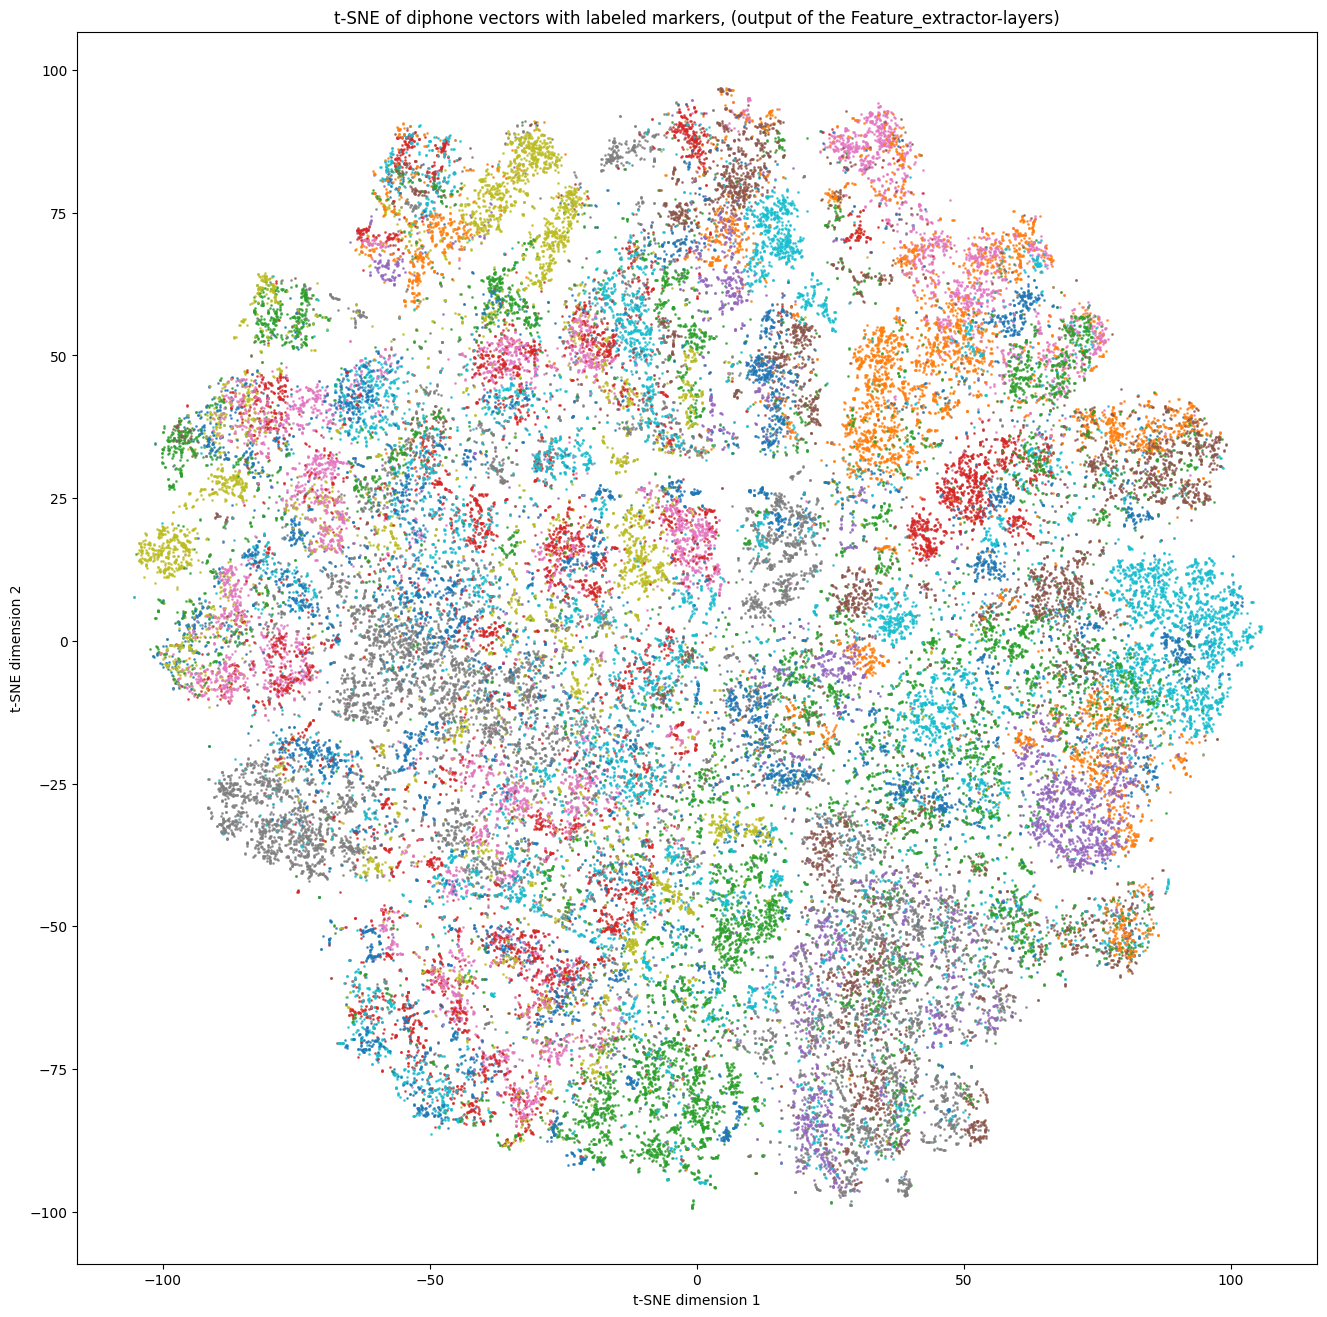

In [95]:
plt.figure(figsize=(16, 16))
Y1=np.array([i[1][1] for i in ALL_list])
markers=list(set(Y1))

for i, marker in enumerate(markers):

    idx = np.where(Y1 == marker)
    
    
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1], label=f'Label {marker}', s=1, alpha=0.7)


#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('t-SNE of diphone vectors with labeled markers, (output of the Feature_extractor-layers)')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.show()

In [83]:
XX=np.array([i[-1].ravel() for i in ALL_list])
YY1=np.array([i[1][0] for i in ALL_list])
YY2=np.array([i[0] for i in ALL_list])

In [86]:
scaler1 = StandardScaler()
X_scaled1 = scaler1.fit_transform(XX)
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
tsne1 = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_tsne1 = tsne1.fit_transform(X_scaled1)

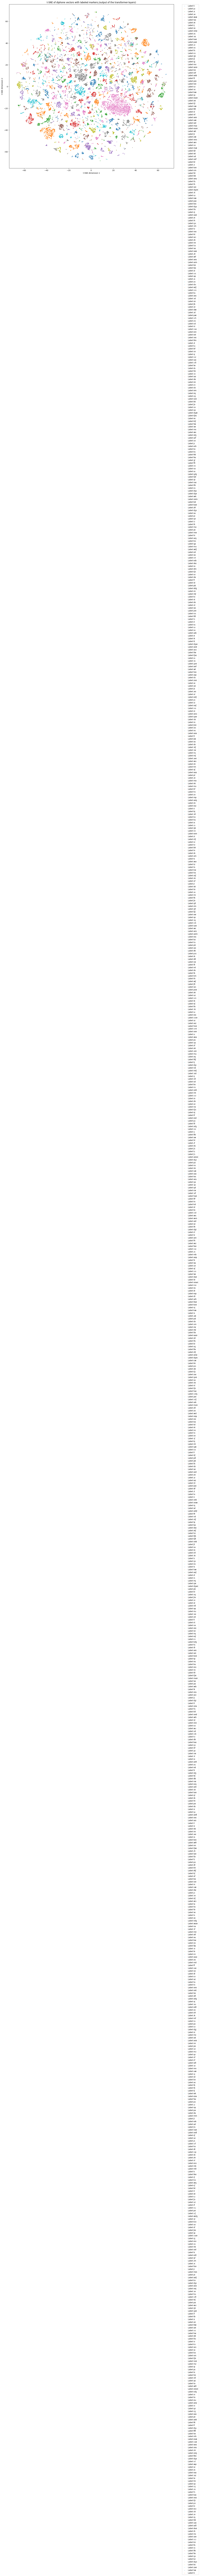

In [89]:
plt.figure(figsize=(16, 16))
YY1=np.array([i[1] for i in ALL_list])
markers=list(set(YY1))

for i, marker in enumerate(markers):

    idx = np.where(YY1 == marker)
    
    
    plt.scatter(X_tsne1[idx, 0], X_tsne1[idx, 1], label=f'Label {marker}', s=1, alpha=0.7)


plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('t-SNE of diphone vectors with labeled markers,(output of the transformer-layers)')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.show()